# Construction of the Appearance Graph

This code responds to the process of creating an Appearance Graph from an Appearance Map as a dataset. This dataset is composed of geolocated images, represented by an appearance descriptor with a pose associated.

In this code, similarity matrices (S) and co-visibility matrices (C) are calculated, along with a JSON file containing pose information. These elements are used in the 'Bipartion_AppearanceGraph' code to construct the Appearance Graph.

### Libraries

In [1]:
import json
import h5py
import cv2 as cv
import os
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

## Co-visibility Matrix - Functions

In this part, two functions are defined for the calculation of the co-visibility matrix.

* The 'CheckCovisibility' function detects co-visibility between two images.
* The 'occupancy' function calculates the percentage of co-visibility once it has been detected.

In [2]:
def CheckCovisibilidad(img1,img2, thr):
# This function detects the presence of co-visibility between two grayscale images.
# It calculates the SIFT descriptors of the images and matches them using the Bruteforce Matcher, creating correspondences between keypoints.
# Based on these correspondences, the Fundamental Matrix is calculated using the RANSAC algorithm.
# The existence of co-visibility is determined if the number of inliers of the Fundamental Matrix exceeds the threshold thr.
#   -Input:
#       img1, img2  ---> Grayscale images to compare.
#       thr         ---> Threshold to determine co-visibility.
#   -Return: 
#       Cov_ENABLE  ---> Boolean indicating the presence of co-visibility.
#       pts1, pts2  ---> Lists of positions on the image planes of matched inliers.

    #Return variables:
    Cov_ENABLE= False   # Co-visibility set to False by default
    pts1=[]
    pts2=[]
    
    # SIFT descriptor class:
    sift=cv.xfeatures2d.SIFT_create()

    # Calculates SIFT descriptors of the images, returns a set of feature descriptors (d)
    # and positions on the image plane, keypoints (kp)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # Matching descriptors using the Bruteforce Matcher (BFM) method.
    if len(kp1) > 0 and len(kp2) > 0:

        bf = cv.BFMatcher(cv.NORM_L2, crossCheck = True)    # BFM class with positive cross-check correlation (crossCheck=True).
        matches = bf.match(des1,des2)                       # Matching of feature descriptors (d).
        matches=sorted(matches, key= lambda x:x.distance)   # The matches are sorted in ascending order based on the distance between pairs of descriptors.
        if len(matches)>100: matches=matches[:100]          # The operations are performed using the 100 matches with the smallest distance, which are the best correspondences.

        # Obtaining keypoints with correspondences:
        for mat in matches:
            pts1.append(kp1[mat.queryIdx].pt)
            pts2.append(kp2[mat.trainIdx].pt)

        pts1=np.int32(np.array(pts1))   # Convert to numpy array
        pts2=np.int32(np.array(pts2))

        # Calculation of the Fundamental Matrix (F) using the RANSAC algorithm.
        if len(pts1)>=50: 
            F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC,3,0.99,10) # Calculating the Fundamental Matrix, with 10 iterations in the RANSAC algorithm.

            # Selecting inliers, which are pairs of keypoints represented by the obtained Fundamental Matrix.
            pts1 = pts1[mask.ravel()==1]
            pts2 = pts2[mask.ravel()==1]
        
            # Detecting co-visibility based on the threshold of the number of inliers.
            if len(pts1)>thr:
                Cov_ENABLE=True

    return Cov_ENABLE, pts1, pts2

In [3]:
def occupancy(pts1,pts2,cell_x,cell_y,size):
# This function calculates the percentage of co-visibility between two images based on the position of the inliers.
# An occupancy grid is defined for each image, where cells containing one or more inliers are marked as occupied.
# The occupancy percentage is calculated as the number of occupied cells divided by the total number of cells.
# The highest occupancy value among the images is chosen to establish the co-visibility percentage in order to obtain a symmetric adjacency matrix.
#   -Input:
#       pts1, pts2      ---> Lists of inliers, positions of features on the image plane.
#       cell_x, cell_y  ---> Occupancy cell size.
#       size            ---> Size of the original images (x,y).
#   -Return: 
#       w               ---> Occupancy percentage, co-visibility value of the edge connecting the nodes.

    # Defining occupancy cells for each image:
    occupancy1=np.array([[0 for i in range(cell_y)] for j in range(cell_x)])
    occupancy2=np.array([[0 for i in range(cell_y)] for j in range(cell_x)])
  
    # We iterate through the lists of inliers and mark the occupied cells.
    iter=len(pts1)
    for i in range(iter):
        #Occupancy 1:
        x1=pts1[i][0]   # X position on the image plane.
        y1=pts1[i][1]   # Y position on the image plane.
        # Adjusting to the size of the occupancy cell:
        x1_idx=np.int32((x1*cell_x)/size[1])    
        y1_idx=np.int32((y1*cell_y)/size[0])
        # Marking the cell as occupied:
        occupancy1[x1_idx][y1_idx]=1
       
        #Occupancy 2:
        x2=pts2[i][0]   # X position on the image plane.
        y2=pts2[i][1]   # Y position on the image plane.
        # Adjusting to the size of the occupancy cell:
        x2_idx=np.int32((x2*cell_x)/size[1])
        y2_idx=np.int32((y2*cell_y)/size[0])
        # Marking the cell as occupied:
        occupancy2[x2_idx][y2_idx]=1
    
    # Summing the occupied cells:
    sum1=0
    sum2=0
    for i in range(cell_y):
        for j in range(cell_x):
            if(occupancy1[j][i]==1):
                sum1+=1
            if(occupancy2[j][i]==1):
                sum2+=1
    
    # Calculating the occupancy percentage as the number of occupied cells divided by the total number of cells:
    occupancy_size=cell_x*cell_y
    w1=np.float64(sum1/occupancy_size)
    w2=np.float64(sum2/occupancy_size)

    # Selecting the maximum occupancy value as the co-visibility percentage between the images.
    w=np.max([w1,w2])   # This is done to achieve a symmetric adjacency matrix for the Appearance Graph.

    return w

## Similarity Matrix - Functions
In this part, the function that calculates the similarity matrix is defined, as well as the function that loads the global descriptors.

In [4]:
def my_similarity(data_set,sim_f):
# This function calculates the similarity matrix for a set of global descriptors of the image.
# It selects all pairs of descriptors from the dataset in order and evaluates the similarity using the 'sim_f' function.
#   -Input:
#       data_set    ---> Appearance map dataset, global descriptors are selected.
#       sim_f       ---> Similarity function for calculating the distance between descriptors.
#   -Return: 
#       sim_matrix  ---> Similarity matrix

    # Selection of global descriptors from the dataset:
    features=np.array(data_set['features'])
    size=len(features)  # Number of descriptors

    # Calculation of the number of iterations to display the process.
    n_iter=(size**2 +size)/2
    cont=0

    # Initializing a square similarity matrix based on the number of descriptors
    sim=[[0 for i in range(size)] for j in range(size)]

    # Loop to compare pairs of descriptors:
    for i in range(0,size):
        for j in range(i,size):
            # Applying the specified similarity function.       
            similarity=sim_f(features[i],features[j])

            # Saving the result in a symmetric similarity matrix.
            sim[i][j]=similarity
            sim[j][i]=similarity
            
            del similarity

            # Print process
            print('Process: ',np.round(((100*cont)/n_iter),2),' %',end='\r')
            cont+=1

    return np.array(sim)

In [5]:
def get_descriptor(general_path):
    # Function to read global descriptors from an h5py file.
    descriptors=[]
    for suffix in os.listdir(general_path):
        f=h5py.File(general_path+suffix,'r')
        descriptors+=f['features']
    return np.array(descriptors)

# Testing

## Load Dataset
This part generates a .json file that represents the Appearance Graph.

It saves information about the image names, poses, appearance descriptors, and odometric poses.

In [6]:
# Set the file path with the dataset's JSON file.
dataset_path=".../dataset/map/"

# Dictionary to store the dataset:
map_dataset=dict(im_paths=[], poses=[], odom_poses=[], features=[])

# Loading poses and paths:
for json_suffix in os.listdir(dataset_path+"Poses/"):    # Folder 'Poses' within the dataset_path.
    json_file=json.load(open(dataset_path+"Poses/"+json_suffix)) 
    samples=len(json_file['im_paths'])
    map_dataset['im_paths']+=json_file['im_paths']
    map_dataset['poses']+=json_file['poses']
    map_dataset['odom_poses']+=json_file['odom_poses']

# Loading image descriptors:
descr_path=dataset_path+'Descriptors/'+'netVLAD/'       # Folder 'Descriptors' within the dataset_path.
features= get_descriptor(descr_path).tolist()           # Function to retrieve image descriptors.
map_dataset['features']+=features                       # Store descriptors in the dictionary

print('Size of dataset: ', len(map_dataset['features']))

Tamaño del dataset:  2146


## Compute of the Similarity Matrix

In [10]:
# Generating an .npy file to store the similarity matrix.
similitud_path='.../Utils/sim_matrix.npy'
if not os.path.exists(similitud_path):
    with open(similitud_path,'x') as fp:
        pass
else:
    fdelet=open(similitud_path,'w')
    fdelet.close()

In [11]:
# Definition of a similarity function, using cosine similarity:
cos_sim=lambda x,y:np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

# Calculating the similarity matrix.
sim_matrix=my_similarity(map_dataset,cos_sim)

# Saving the similarity matrix.
np.save(similitud_path, sim_matrix)

## Compute of the Co-visibility Matrix

In [12]:
# Generating an .npy file to store the co-visibility matrix.
covisibilidad_path='.../Utils/cov_matrix.npy'
if not os.path.exists(covisibilidad_path):
    with open(covisibilidad_path,'x') as fp:
        pass
else:
    fdelet=open(covisibilidad_path,'w')
    fdelet.close()

In [13]:
# Specify the path to the images in the dataset.
img_path= ".../map/Images"

# Saving a list with the names of the images.
im_dir=[]
for suffix in sorted(os.listdir(img_path)):
    im_dir.append(suffix)

im_size=len(im_dir) # Number of images

We initialize binary co-visibility and weight matrices.

In [ ]:
overlap=np.zeros([im_size, im_size], dtype=np.bool) # Binary co-visibility matrix, saving the result of the co-visibility detection.
cov_matrix=np.zeros([im_size, im_size], dtype=np.float64)    # Real co-visibility matrix, saving the co-visibility percentage.

### Compute of the Co-visibility Matrix
The co-visibility percentage is calculated for every pairs of images in the Çdataset.

In [15]:
# Calculation of the number of iterations to display the progress of the process
total_iter=(np.math.factorial(im_size)/(np.math.factorial(2)*np.math.factorial(im_size-2)))+im_size
cont_iter=0

# Setting the threshold value of the number of inliers to determine co-visibility.
thr=20

# Loop that compares pairs of images.
for i in range(im_size):
    # Load image 1:
    suffix1=im_dir[i]
    im1=cv.imread(img_path+'/'+suffix1)

    for j in range(i,im_size):
        # Load image 2:
        suffix2=im_dir[j]
        im2=cv.imread(img_path+'/'+suffix2)

        if i==j:    # If the images to compare are the same (same index), co-visibility is directly determined as 1.
            overlap[i][j]=True
            cov_matrix[i][j]=1

        else:
            # Co-visibility detection
            ovlp,pts1,pts2=CheckCovisibilidad(im1,im2,thr)
            overlap[i, j]=ovlp
            overlap[j, i]=ovlp

            # If co-visibility is detected, the occupancy percentage calculation is performed.
            if(ovlp):
                tam=im1.shape   # Original image size
                cell_x=6        # Occupancy cell size in the x-axis.
                cell_y=np.int32((tam[0]/tam[1])*cell_x) # Occupancy cell size in the y-axis, relative to image dimensions.
                
                # Occupancy percentage calculation
                cov_ratio=occupancy(pts1,pts2,cell_x,cell_y,tam)

                # Saving the occupancy percentage in the symmetric co-visibility matrix.
                cov_matrix[i, j]=cov_ratio
                cov_matrix[j, i]=cov_ratio
            
                del cov_ratio
            
            # If co-visibility is not detected, a value of 0 is assigned
            else:
                cov_matrix[i, j]=0
                cov_matrix[j, i]=0

            del ovlp, pts1,pts2

        # Printing the execution percentage
        cont_iter+=1
        if j%10==0: print('Process: ',np.round((cont_iter/total_iter)*100,decimals=6),'%',end='\r')


    # Saving the co-visibility matrix.
    np.save(covisibilidad_path,cov_matrix)        

## Post-processing

In this part, isolated nodes are removed from the co-visibility matrix. These are nodes that are not connected to any other node and are not necessary for the topological map.

They are also removed from the similarity matrix and the pose dataset of the map. The final versions are saved.

In [ ]:
# Determining the indices whose rows sum to a value greater than 1 in the co-visibility matrix, indicating that they are connected to at least one node.
indx = np.argwhere(cov_matrix.sum(0) > 1).reshape([-1])
tam=cov_matrix.shape[0]
print('There are %d bad indices. Cleaning up.' % (tam - len(indx)))

# The indices of the good nodes are saved in the matrices.
cov_matrix = cov_matrix[indx][:, indx]
sim_matrix = sim_matrix[indx][:, indx]

# Saving the good indices in the dataset
save_dataset=dict(im_paths=[], poses=[], odom_poses=[], features=[])    # Creating a new dictionary to store the final map.
for key in map_dataset.keys():
    arr=np.array(map_dataset[key])
    arr=arr[indx]                   # Selection of elements with good indices.
    save_dataset[key]=arr.tolist()  # Saving the lists in a new dictionary.

Hay 0 indices malos. Limpiamos


Saving the result

In [ ]:
# Final map .json file path
save_json=".../Utils/Appearance_Graph.json"

with open(save_json, "w") as outfile:
    json.dump(save_dataset, outfile)

np.save(covisibilidad_path,cov_matrix)  
np.save(similitud_path,sim_matrix)  

# Show matrix

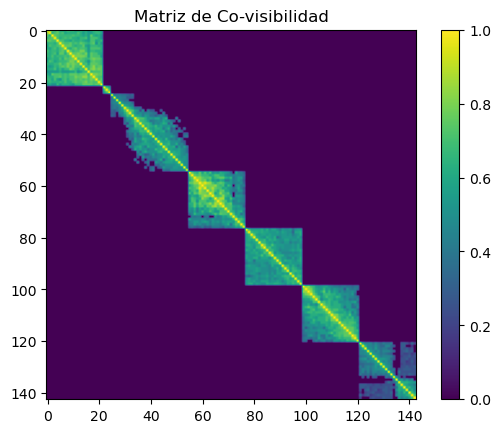

In [ ]:
plt.imshow(cov_matrix)
plt.title('Co-visibility Matrix')
plt.colorbar()
plt.show()

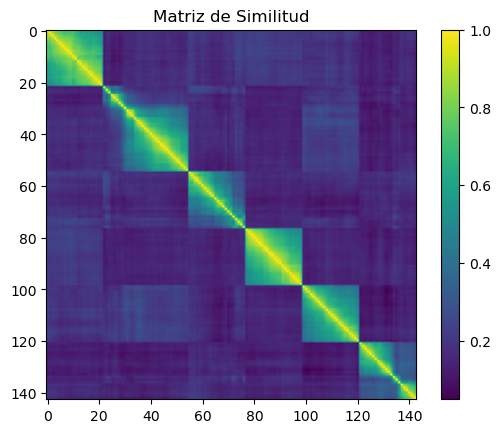

In [ ]:
plt.imshow(sim_matrix)
plt.title('Similarity Matrix')
plt.colorbar()
plt.show()

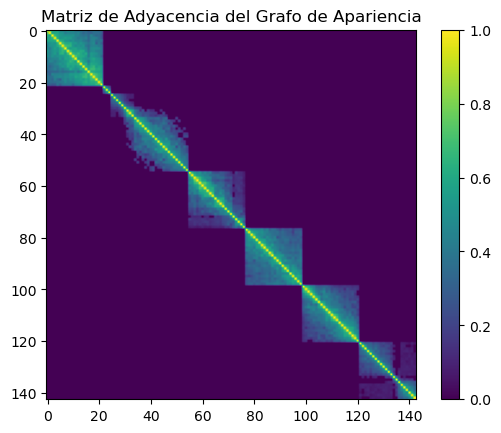

In [ ]:
plt.imshow(cov_matrix*sim_matrix)
plt.title('Adjacency matrix of the Appearance Graph.')
plt.colorbar()
plt.show()